<a href="https://colab.research.google.com/github/rll/deepul/blob/master/homeworks/hw1/hw1_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Started

## Overview
This semester, all homeworks will be conducted through Google Colab notebooks. All code for the homework assignment will be written and run in this notebook. Running in Colab will automatically provide a GPU, but you may also run this notebook locally by following [these instructions](https://research.google.com/colaboratory/local-runtimes.html) if you wish to use your own GPU.

You will save images in the notebooks to use and fill out a given LaTeX template which will be submitted to Gradescope, along with your notebook code.

## Using Colab
On the left-hand side, you can click the different icons to see a Table of Contents of the assignment, as well as local files accessible through the notebook.

Make sure to go to **Runtime -> Change runtime type** and select **GPU** as the hardware accelerator. This allows you to use a GPU. Run the cells below to get started on the assignment. Note that a session is open for a maximum of 12 hours, and using too much GPU compute may result in restricted access for a short period of time. Please start the homework early so you have ample time to work.

**If you loaded this notebook from clicking "Open in Colab" from github, you will need to save it to your own Google Drive to keep your work.**

## General Tips
In each homework problem, you will implement an autoregressive model and run it on two datasets (dataset 1 and dataset 2). The expected outputs for dataset 1 are already provided to help as a sanity check.

Feel free to print whatever output (e.g. debugging code, training code, etc) you want, as the graded submission will be the submitted pdf with images.

After you complete the assignment, download all of the image outputted in the results/ folder and upload them to the figure folder in the given latex template.

Run the cells below to download and load up the starter code.

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sat Jun 27 03:17:18 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!if [ -d deepul ]; then rm -Rf deepul; fi
!git clone https://github.com/rll/deepul.git 
!unzip -qq deepul/homeworks/hw1/data/hw1_data.zip -d deepul/homeworks/hw1/data/
!pip install ./deepul

Cloning into 'deepul'...
remote: Enumerating objects: 749, done.
remote: Total 749 (delta 0), reused 0 (delta 0), pack-reused 749
Receiving objects: 100% (749/749), 114.90 MiB | 33.73 MiB/s, done.
Resolving deltas: 100% (344/344), done.
Checking out files: 100% (129/129), done.
Processing ./deepul
  Created wheel for deepul: filename=deepul-0.1.0-cp36-none-any.whl size=16679 sha256=9b9272c7cc91afb3d25271decd76a2f09d4e4a9611e74c9c118c6204e466f76c
  Stored in directory: /tmp/pip-ephem-wheel-cache-qu67uvdf/wheels/39/1a/4b/a6f51db275abb2e5dae32540e06ed5011e792f162467bd3aa8
Successfully built deepul


In [ ]:
import numpy as np
from deepul.hw1_helper import *
from matplotlib import cycler
from tqdm import trange
from tqdm.notebook import tqdm

import torch 
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import deepul.pytorch_util as ptu

%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 6.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'viridis'
colors = cycler('color',
                ['#EE6666', '#3388BB', '#9988DD',
                 '#EECC55', '#88BB44', '#FFBBBB'])
plt.rc('axes', facecolor='#E6E6E6', edgecolor='none',
       axisbelow=True, grid=True, prop_cycle=colors)
plt.rc('grid', color='lightgray', linestyle='solid')
plt.rc('xtick', direction='out', color='lightgray')
plt.rc('ytick', direction='out', color='lightgray')
plt.rc('patch', edgecolor='#E6E6E6')
plt.rc('lines', linewidth=2)
plt.rc('text', color='lightgray')
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [ ]:
import deepul.pytorch_util as ptu

if torch.cuda.is_available():
  ptu.set_gpu_mode(True)
  print("Using GPU Runtime")
else:
  ptu.set_gpu_mode(False)
  print("Using cpu runtime")

Using GPU Runtime


In [ ]:
def train(model, train_loader, optimizer):
  model.train()

  losses = []
  for i, x in enumerate(train_loader):
    x = x.to(ptu.device).contiguous()
    loss = model.loss(x)
    losses.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  return losses

def eval_loss(model, data_loader):
  model.eval()
  loss = 0.
  with torch.no_grad():
    for x in data_loader:
      x = x.to(ptu.device).contiguous()

      loss += model.loss(x) * x.shape[0]
    
    loss /= len(data_loader.dataset)
  return loss.item()

def train_epochs(model, train_loader, test_loader, epochs=40, lr=1e-2, optimizer=None, quiet=True):
  if optimizer is None:
    optimizer = optim.Adam(model.parameters(), lr=lr)

  train_losses, test_losses = [], []

  test_loss = eval_loss(model, test_loader)
  test_losses.append(test_loss)

  for epoch in tqdm(range(epochs), desc='Epochs', leave=True):
    model.train()

    train_loss = train(model, train_loader, optimizer)
    train_losses += train_loss

    test_loss = eval_loss(model, test_loader)
    test_losses.append(test_loss)

    if quiet == False and epoch % 5 == 0 :
      print(f"Train loss {train_loss[-1]} - Test loss {test_loss}")      

  return train_losses, test_losses

In [ ]:
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |
|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |
|---------------------------------------------------------------------------|
| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |

In [ ]:
import torch
import sys
import gc
for obj in gc.get_objects():
    try:
        if torch.is_tensor(obj) or (hasattr(obj, 'data') and torch.is_tensor(obj.data)):
            print(type(obj), obj.size(), sys.getsizeof(obj))
    except:
        pass

/usr/local/lib/python3.6/dist-packages/pandas/util/__init__.py:23: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  
/usr/local/lib/python3.6/dist-packages/torch/distributed/distributed_c10d.py:102: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn("torch.distributed.reduce_op is deprecated, please use "


# Question 1: 1D Data

In this question, we will train simple generative models on discrete 1D data.

Execute the cell below to visualize our datasets

Dataset 1


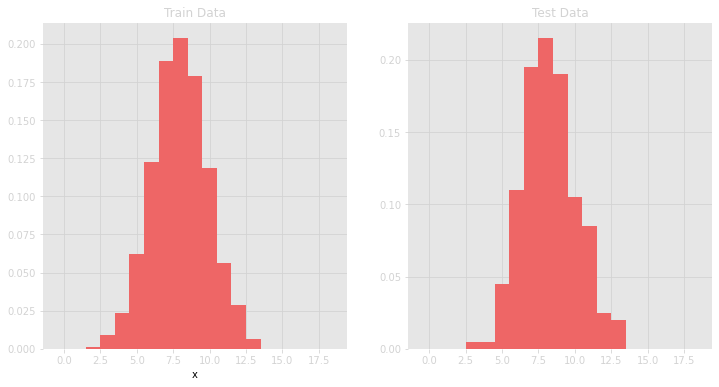

Dataset 2


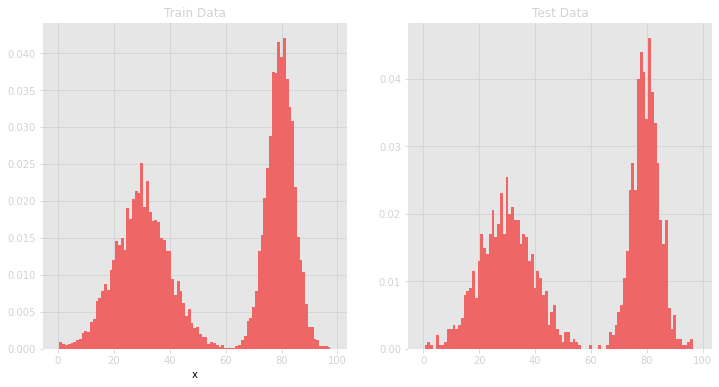

In [ ]:
visualize_q1_data(dset_type=1)
visualize_q1_data(dset_type=2)

## Part (a) Fitting a Histogram

Let $\theta = (\theta_0, \dots, \theta_{d-1}) \in \mathbb{R}^d$ and define the model $p_\theta(x) = \frac{e^{\theta_x}}{\sum_{x'}e^{\theta_{x'}}}$

Fit $p_\theta$ with maximum likelihood via stochastic gradient descent on the training set, using $\theta$ initialized to zero. Use your favorite version of stochastic gradient descent, and optimize your hyperparameters on a validation set of your choice.

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. Plot the model probabilities in a bar graph with $\{0,\dots,d-1\}$ on the x-axis and a real number in $[0,1]$ on the y-axis.




### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
 class Histogram(nn.Module):
  def __init__(self, d):
    super().__init__()
    self.d = d
    self.theta = torch.nn.Parameter(ptu.zeros(d, requires_grad=True))

  def distribution(self):
    return F.softmax(self.theta, dim=0).detach().cpu().numpy() 

  def loss(self, x):
    weights = self.theta.unsqueeze(0).repeat(x.shape[0], 1)
    return F.cross_entropy(weights, x)

In [ ]:
def q1_a(train_data, test_data, d, dset_id):
  """
  train_data: An (n_train,) numpy array of integers in {0, ..., d-1}
  test_data: An (n_test,) numpy array of integers in {0, .., d-1}
  d: The number of possible discrete values for random variable x
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
             used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (d,) of model probabilities
  """
  train_loader = data.DataLoader(train_data, batch_size=128, shuffle=True, pin_memory=True)
  test_loader = data.DataLoader(test_data, batch_size=128, pin_memory=True)

  model = Histogram(d).to(ptu.device)
  train_losses, test_losses = train_epochs(model, train_loader, test_loader, epochs=1000)

  return train_losses, test_losses, model.distribution()

### Results

Once you've implemented `q1_a`, execute the cells below to visualize and save your results




Final Test Loss: 2.0505


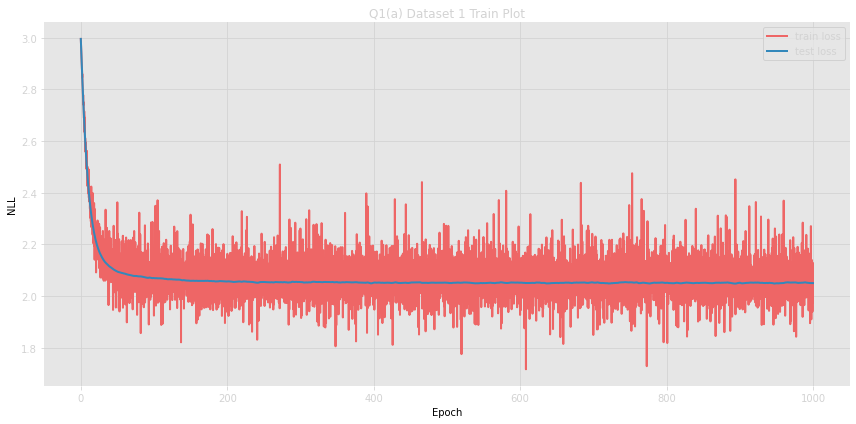

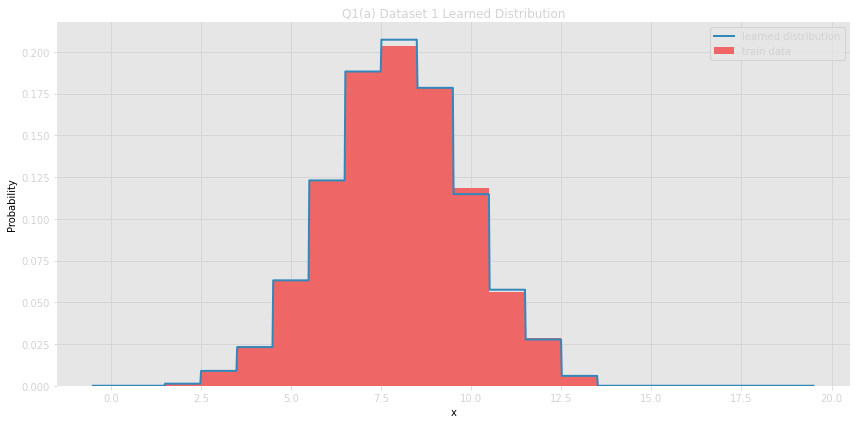

In [ ]:
q1_save_results(1, 'a', q1_a) 


Final Test Loss: 4.0329


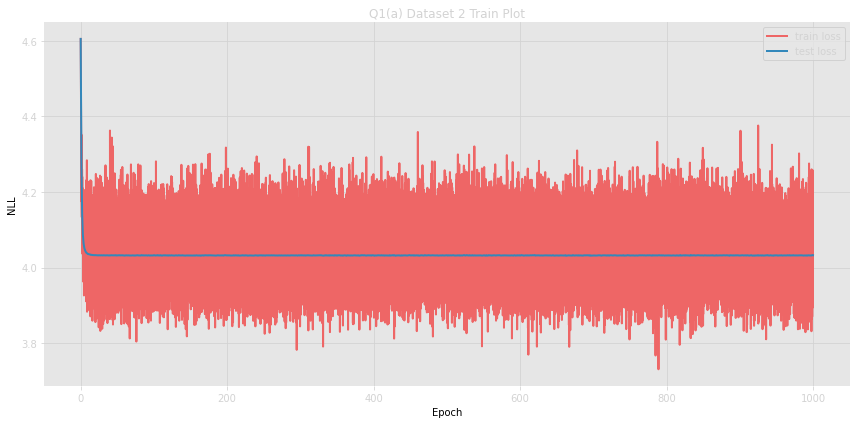

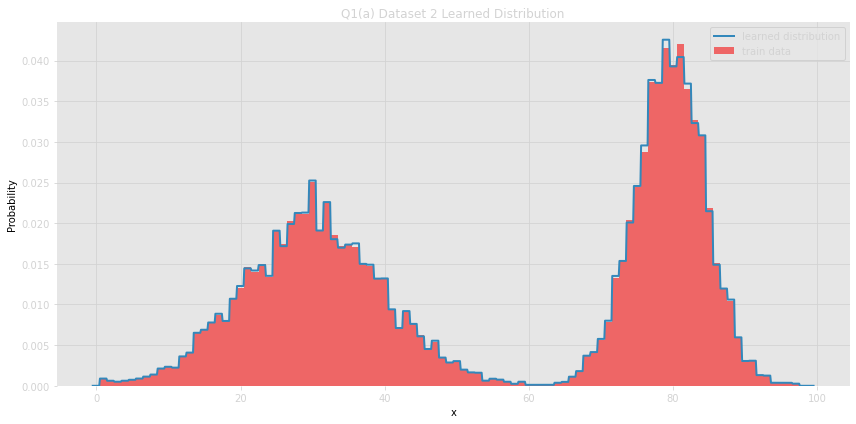

In [ ]:
q1_save_results(2, 'a', q1_a)

## Part (b) Fitting Discretized Mixture of Logistics

Let us model $p_\theta(x)$ as a **discretized** mixture of 4 logistics such that $p_\theta(x) = \sum_{i=1}^4 \pi_i[\sigma((x+0.5 - \mu_i)/s_i) - \sigma((x-0.5-\mu_i)/s_i)]$

For the edge case of when $x = 0$, we replace $x-0.5$ by $-\infty$, and for $x = d-1$, we replace $x+0.5$ by $\infty$.

You may find the [PixelCNN++](https://arxiv.org/abs/1701.05517) helpful for more information on discretized mixture of logistics.

**Provide the same set of corresponding deliverables as part (a)**

### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
class LogisticMix(nn.Module):
  def __init__(self, d, n_components=4):
    super().__init__()
    self.d = d # number of possible values that a variable can take
    self.n_components = n_components

    self.weights = nn.Parameter(ptu.zeros((self.n_components,)), requires_grad=True) # We pass these through a sigmoid to get the \pi_i's
    self.mu = nn.Parameter(torch.rand(self.n_components, device=ptu.device), requires_grad=True)
    self.log_scales = nn.Parameter(torch.rand(self.n_components, device=ptu.device), requires_grad=True)

  def distribution(self):
    with torch.no_grad():
      probs = self.log_likelihood(torch.arange(self.d)).exp()
      return probs.detach().cpu().numpy()

  def log_likelihood(self, x):
    d = self.d
    x = x.to(ptu.device)
    x = x.unsqueeze(1).repeat(1, self.n_components)
    log_pi = F.log_softmax(self.weights, dim=0).unsqueeze(0)
    log_scales = self.log_scales.unsqueeze(0)
    mu = self.mu.unsqueeze(0)

    inv_scales = torch.exp(-log_scales)

    plus_in = inv_scales * (x + 0.5 - mu)
    minus_in = inv_scales * (x - 0.5 - mu)

    cdf_plus = torch.sigmoid(plus_in)
    cdf_minus = torch.sigmoid(minus_in)
    
    cdf_delta = cdf_plus - cdf_minus
    log_cdf_delta = torch.log(torch.clamp(cdf_delta, min=1e-12))

    # Clamping on the edges
    log_cdf_plus = torch.log(torch.clamp(torch.sigmoid(inv_scales * (0 + 0.5 - mu)), min=1e-12))
    log_cdf_minus = torch.log(torch.clamp(1 - torch.sigmoid(inv_scales * ((d - 1) - 0.5 - mu)), min=1e-12))

    x_log_probs = torch.where(x < 1e-5, log_cdf_plus, 
                              torch.where(x > d - 1 - 1e-5, log_cdf_minus, log_cdf_delta))
    return torch.logsumexp(x_log_probs + log_pi, dim=1)

  def loss(self, x):
    return -torch.mean(self.log_likelihood(x))

In [ ]:
def q1_b(train_data, test_data, d, dset_id):
  """
  train_data: An (n_train,) numpy array of integers in {0, ..., d-1}
  test_data: An (n_test,) numpy array of integers in {0, .., d-1}
  d: The number of possible discrete values for random variable x
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (d,) of model probabilities
  """
  
  train_loader = data.DataLoader(train_data, batch_size=128, shuffle=True)
  test_loader = data.DataLoader(test_data, batch_size=128)

  model = LogisticMix(d, n_components=8).to(ptu.device)
  train_losses, test_losses = train_epochs(model, train_loader, test_loader, epochs=200)

  return train_losses, test_losses, model.distribution()

### Results

Once you've implemented `q1_b`, execute the cells below to visualize and save your results




Final Test Loss: 2.0596


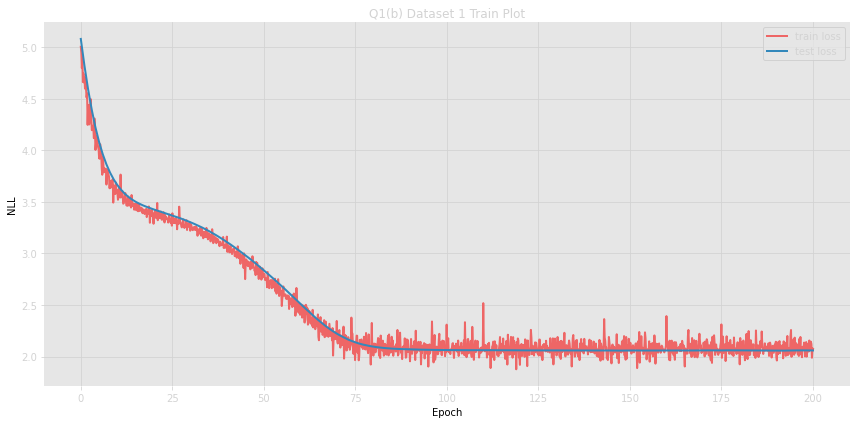

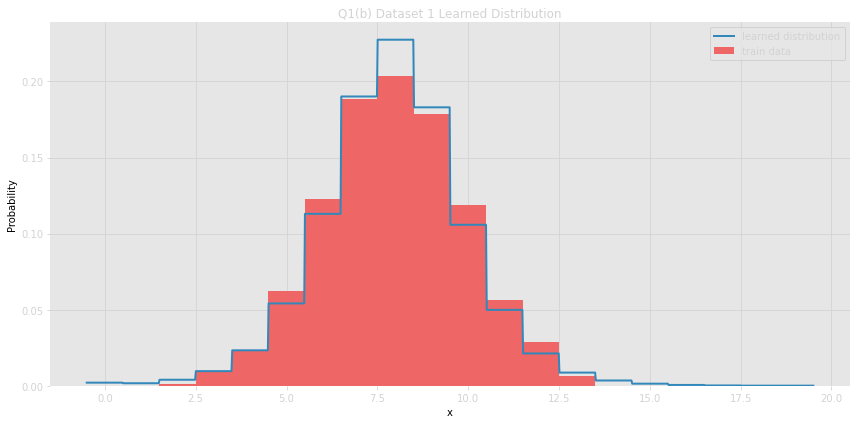

In [ ]:
q1_save_results(1, 'b', q1_b)


Final Test Loss: 4.0347


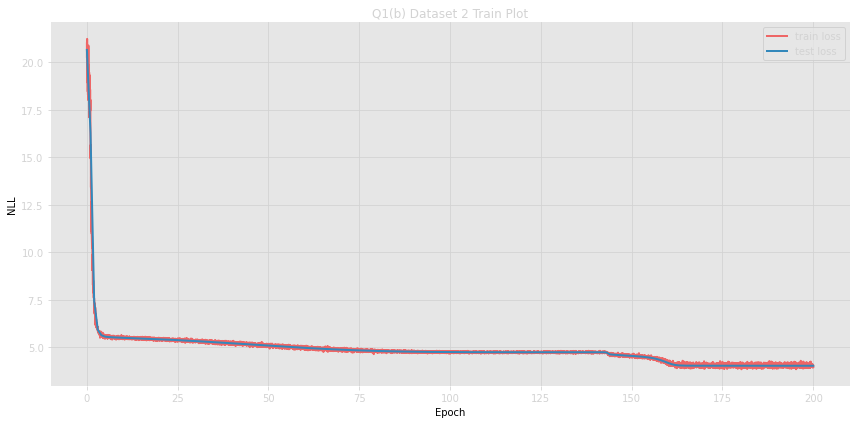

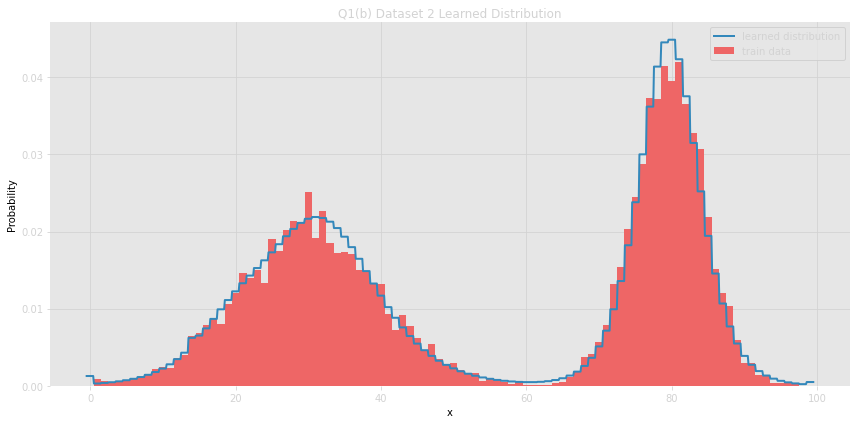

In [ ]:
q1_save_results(2, 'b', q1_b)

# Question 2: MADE

In this question, you will implement [MADE](https://arxiv.org/abs/1502.03509). In the first part, you will use MADE to model a simple 2D joint distribution, and in the second half, you will train MADE on image datasets.

## Part (a) Fitting 2D Data

First, you will work with bivariate data of the form $x = (x_0,x_1)$, where $x_0, x_1 \in \{0, \dots, d\}$. We can easily visualize a 2D dataset by plotting a 2D histogram. Run the cell below to visualize our datasets.

Dataset 1


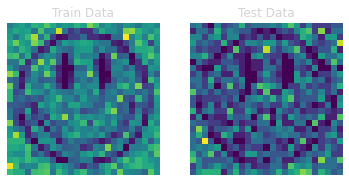

Dataset 2


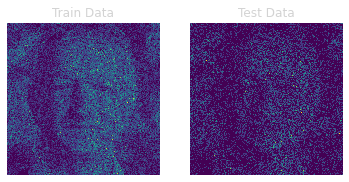

In [ ]:
visualize_q2a_data(dset_type=1)
visualize_q2a_data(dset_type=2)

Implement and train a MADE model through maximum likelihood to represent $p(x_0, x_1)$ on the given datasets, with any autoregressive ordering of your choosing. 

A few notes:
* You do not need to do training with multiple masks
* You made find it useful to one-hot encode your inputs. 

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. Visualize the learned 2D distribution by plotting a 2D heatmap


### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
class MaskedLinear(nn.Linear):
  def __init__(self, in_features, out_features, bias=True):
    super().__init__(in_features, out_features, bias=bias)
    self.register_buffer('mask', torch.ones(out_features, in_features))

  def forward(self, x):
    return F.linear(x, self.weight * self.mask, self.bias)

  def set_mask(self, mask):
    new_mask = torch.from_numpy(mask.astype(np.uint8))
    self.mask.data.copy_(new_mask)

In [ ]:
def to_one_hot(x, num_classes):
  z = torch.zeros(*x.shape, num_classes, device=ptu.device)
  return z.scatter_(-1, x.unsqueeze(-1), 1)

In [ ]:
class MADE(nn.Module): 
  """
  We have n_inputs, each taking values from [1, d]. 
  We'll one-hot encode them, and pass them through a masked MLP, with a softmax at the end
  to create, *for each input* a vector [y_1, ..., y_d] representing the probabilities of each value

  Therefore the our network has shape [n_inputs*d, *hidden_layers, n_inputs*d]
  """  

  def __init__(self, d, input_shape, hidden_sizes, one_hot=False):


    super().__init__()
    self.d = d
    self.m = {}
    self.input_shape = input_shape
    self.n_inputs = np.prod(self.input_shape)
    self.n_outputs = self.n_inputs * d
    self.hidden_sizes = hidden_sizes
    self.one_hot = one_hot

    # set up regular MLP
    layers = []
    sizes = [self.n_inputs * d if self.one_hot else self.n_inputs] + self.hidden_sizes + [self.n_outputs]

    for input_size, output_size in zip(sizes, sizes[1:]):
      layers.append(MaskedLinear(input_size, output_size))
      layers.append(nn.ReLU())
    # Remove the last ReLU
    layers.pop()

    self.layers = nn.Sequential(*layers) 
    self.set_masks()

  def set_masks(self):
    self.m[-1] = np.arange(1, self.n_inputs + 1) # ordering

    L = len(self.hidden_sizes)
    for l in range(L):
      self.m[l] = np.random.randint(np.min(self.m[l-1]), self.n_inputs, size=self.hidden_sizes[l])

    masks = [(self.m[l][:, None] >= self.m[l-1][None, :]) for l in range(L)]
    masks.append((self.m[-1][:, None] >  self.m[L-1][None, :]))

    # Repeat the last mask to accomodate for all the inputs, outputs
    masks[-1] = np.repeat(masks[-1], self.d, axis=0)

    if self.one_hot:
      masks[0] = np.repeat(masks[0], self.d, axis=1)

    layers = [l for l in self.layers.modules() if isinstance(l, MaskedLinear)]
    for layer, mask in zip(layers, masks):
      layer.set_mask(mask)

  def forward(self, x):
    batch_size = x.shape[0]
    if self.one_hot:
      x = F.one_hot(x, num_classes=self.d).float()
      x = x.view(batch_size, -1)
    else:
      x = x.view(batch_size, -1)

    probs = self.layers(x.float())
    logits = probs.view(batch_size, self.n_inputs, self.d).permute(0, 2, 1)
    return logits.view(batch_size, self.d, *self.input_shape)

  def loss(self, x):
    return F.cross_entropy(self(x), x.long())

  def sample(self, num_samples):
    samples = torch.zeros(num_samples, self.n_inputs, device=ptu.device)

    with torch.no_grad():
      for i in range(self.n_inputs):
        logits = self(samples).view(num_samples, self.d, self.n_inputs, -1)[:, :, i]
        probs = F.softmax(logits, dim=1)
        sample = torch.multinomial(probs.squeeze(-1), 1).squeeze(-1)
        samples[:, i] = sample

    samples = samples.view((num_samples, *self.input_shape))
    return samples.detach().cpu().numpy()

  def distribution(self):
    x = np.mgrid[0:self.d, 0:self.d].reshape(2, self.d ** 2).T
    x = torch.from_numpy(x).to(ptu.device)
    log_probs = F.log_softmax(self(x), dim=1)
    distribution = torch.gather(log_probs, 1, x.unsqueeze(1)).squeeze(1)
    distribution = distribution.sum(dim=1)
    return distribution.exp().view(self.d, self.d).detach().cpu().numpy()

In [ ]:
def q2_a(train_data, test_data, d, dset_id):
  """
  train_data: An (n_train, 2) numpy array of integers in {0, ..., d-1}
  test_data: An (n_test, 2) numpy array of integers in {0, .., d-1}
  d: The number of possible discrete values for each random variable x1 and x2
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (d, d) of probabilities (the learned joint distribution)
  """
  
  train_loader = data.DataLoader(train_data, batch_size=128, shuffle=True)
  test_loader = data.DataLoader(test_data, batch_size=128)

  model = MADE(d, (2,), [1024, 1024, 1024, 1024], one_hot=True).to(ptu.device)

  train_losses, test_losses = train_epochs(model, train_loader, test_loader, epochs=100, lr=1e-4)

  return train_losses, test_losses, model.distribution()

### Results

Once you've implemented `q2_a`, execute the cells below to visualize and save your results




Final Test Loss: 3.1931


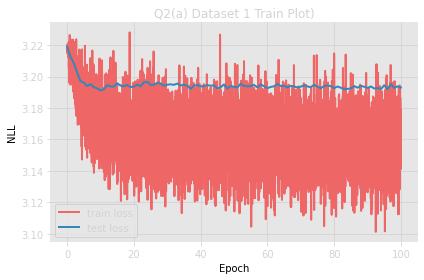

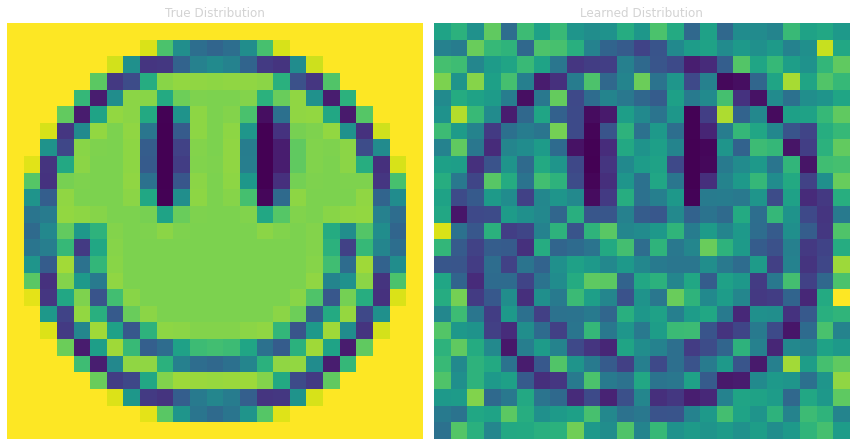

In [ ]:
q2_save_results(1, 'a', q2_a)


Final Test Loss: 5.3790


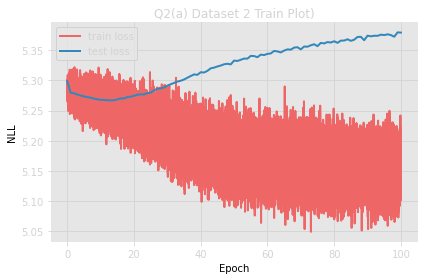

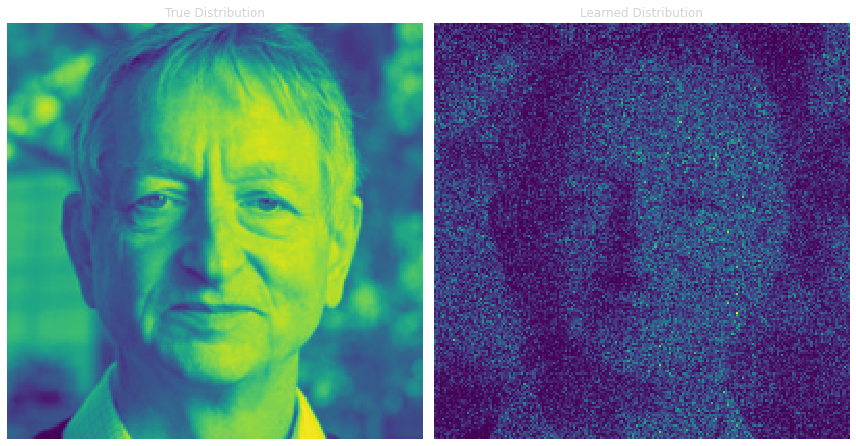

In [ ]:
q2_save_results(2, 'a', q2_a)

## Part (b) Shapes and MNIST
Now, we will work with a higher dimensional datasets, namely a shape dataset and MNIST. Run the cell below to visualize the two datasets

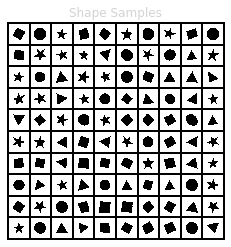

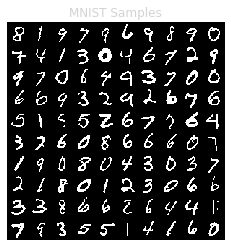

In [ ]:
visualize_q2b_data(1)
visualize_q2b_data(2)

Implement and train a MADE model on the given binary image datasets. Given some binary image of height $H$ and width $W$, we can represent image $x\in \{0, 1\}^{H\times W}$ as a flattened binary vector $x\in \{0, 1\}^{HW}$ to input into MADE to model $p_\theta(x) = \prod_{i=1}^{HW} p_\theta(x_i|x_{<i})$. Your model should output logits, after which you could apply a sigmoid over 1 logit, or a softmax over two logits (either is fine).

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model

### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
def q2_b(train_data, test_data, image_shape, dset_id):
  """
  train_data: A (n_train, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
  test_data: An (n_test, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
  image_shape: (H, W), height and width of the image
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, W, 1) of samples with values in {0, 1}
  """

  H, W = image_shape  
  train_loader = data.DataLoader(train_data, batch_size=128, shuffle=True)
  test_loader = data.DataLoader(test_data, batch_size=128)

  model = MADE(2, (H, W, 1), [1024, 1024, 1024, 1024]).to(ptu.device)
  train_losses, test_losses = train_epochs(model, train_loader, test_loader, epochs=500, lr=1e-5)

  return train_losses, test_losses, model.sample(100)

### Results

Once you've implemented `q2_b`, execute the cells below to visualize and save your results



/usr/local/lib/python3.6/dist-packages/deepul/pytorch_util.py:116: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(*args, **kwargs, device=torch_device)



Final Test Loss: 0.0865


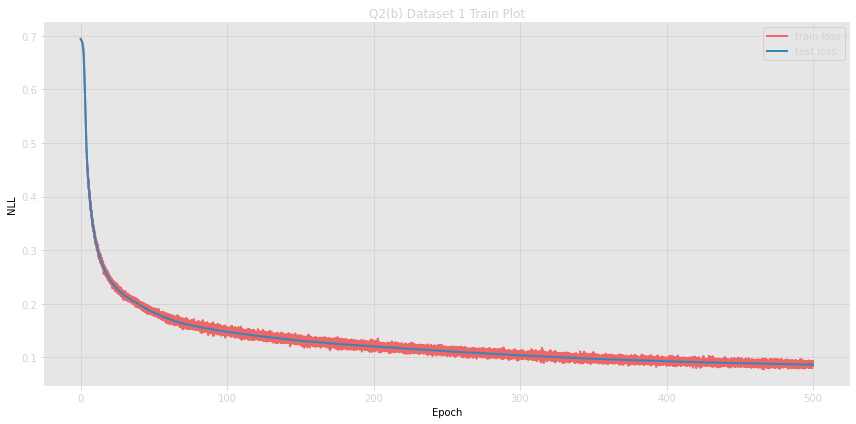

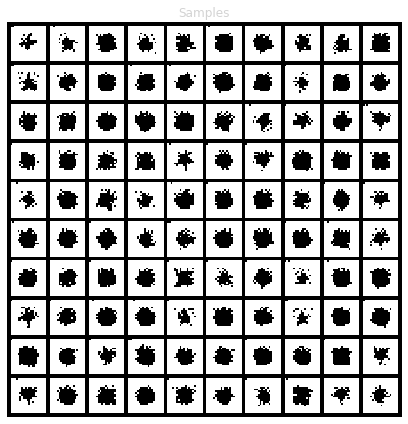

In [ ]:
q2_save_results(1, 'b', q2_b)

/usr/local/lib/python3.6/dist-packages/deepul/pytorch_util.py:116: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(*args, **kwargs, device=torch_device)



Final Test Loss: 0.1343


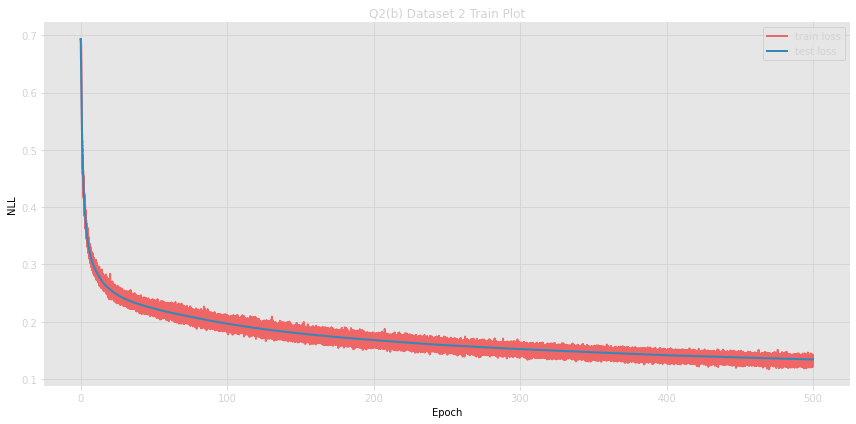

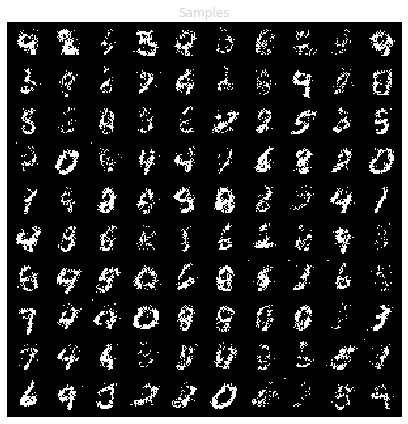

In [ ]:
q2_save_results(2, 'b', q2_b)

# Question 3 PixelCNNs

Now, you will train more powerful PixleCNN models on the shapes dataset and MNIST. In addition, we will extend to modelling colored datasets with and without channel conditioning.



## Part (a) PixelCNN on Shapes and MNIST
In this part, implement a simple PixelCNN architecture to model binary MNIST and shapes images (same as Q2(b), but with a PixelCNN).

We recommend the following network design:
* A $7 \times 7$ masked type A convolution
* $5$ $7 \times 7$ masked type B convolutions
* $2$ $1 \times 1$ masked type B convolutions
* Appropriate ReLU nonlinearities in-between
* 64 convolutional filters

And the following hyperparameters:
* Batch size 128
* Learning rate $10^{-3}$
* 10 epochs
* Adam Optimizer (this applies to all PixelCNN models trained in future parts)

Your model should output logits, after which you could apply a sigmoid over 1 logit, or a softmax over two logits (either is fine). It may also help to scale your input to $[-1, 1]$ before running it through the network. 

Training on the shapes dataset should be quick, and MNIST should take around 10 minutes

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model



### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
class PixelConv2d(nn.Conv2d):
  """
  PixelConv2d for greyscale
  """
  def __init__(self, in_channels, out_channels, kernel_size, mask_type, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros'):
    super().__init__(in_channels, out_channels, kernel_size, 
                     stride=stride, padding=padding, dilation=dilation,
                     groups=groups, bias=bias, padding_mode=padding_mode)

    F, C, K, K = self.weight.shape

    self.mask_type = mask_type
    self.register_buffer('mask', torch.zeros(K, K))


    half = int(K * K / 2)
    threshold = half if self.mask_type == 'a' else half + 1
    idx = 0
    while idx < threshold:
      i, j = divmod(idx, K)
      self.mask[i, j] = 1
      idx += 1

  def forward(self, input):
    return F.conv2d(input, self.weight * self.mask, self.bias, self.stride, 
                    self.padding, self.dilation, self.groups)


In [ ]:
class PixelCNN(nn.Module):
  def __init__(self, num_hidden_layers=3, num_fc_layers=1):    
    """
    A  7×7  masked type A convolution
    5   7×7  masked type B convolutions
    2   1×1  masked type B convolutions
    """
    super().__init__()

    layers = [PixelConv2d(1, 64, 7,'a', padding=3)] + \
             [nn.ReLU(), PixelConv2d(64, 64, 3, 'b', padding=1)] * num_hidden_layers + \
             [nn.ReLU(), PixelConv2d(64, 64, 1, 'b')] * num_fc_layers + \
             [nn.ReLU(), PixelConv2d(64, 2, 1, 'b')] 

    self.layers = nn.Sequential(*layers)

  def sample(self, image_shape, num_samples):
    samples = torch.zeros(num_samples, 1, *image_shape, device=ptu.device) 

    H, W = image_shape

    with torch.no_grad():
      for i in range(H):
        for j in range(W):
          logits = self(samples)

          probs = F.softmax(logits[:, :, i, j], dim=1)
          sample = torch.multinomial(probs, 1)          
          samples[:, :, i, j] = sample

    samples = samples.permute(0, 2, 3, 1)
    return samples.detach().cpu().numpy()

  def forward(self, x):
    return self.layers(x)

  def loss(self, x):
    x = x.float()
    logits = self(x) 
    probs = F.softmax(logits, dim=1) 
    return F.cross_entropy(logits.float(), x.squeeze(1).long()) # TODO: FIX THIS, it should be probs not logits here

In [ ]:
def q3_a(train_data, test_data, image_shape, dset_id):
  """
  train_data: A (n_train, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
  test_data: A (n_test, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
  image_shape: (H, W), height and width of the image
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, W, 1) of samples with values in {0, 1}
  """
  
  model = PixelCNN(num_hidden_layers=10, num_fc_layers=5).to(ptu.device)

  train_data = np.transpose(train_data, (0, 3, 1, 2))
  test_data = np.transpose(test_data, (0, 3, 1, 2))

  train_loader = data.DataLoader(train_data, batch_size=64, shuffle=True, )
  test_loader = data.DataLoader(test_data, batch_size=64)

  optimizer = optim.Adam(model.parameters(), lr=1e-3)
  train_losses, test_losses = train_epochs(model, train_loader, test_loader, epochs=10, optimizer=optimizer)
  samples = model.sample(image_shape, 100)

  return train_losses, test_losses, samples

### Results

Once you've implemented `q3_a`, execute the cells below to visualize and save your results




Final Test Loss: 0.0591


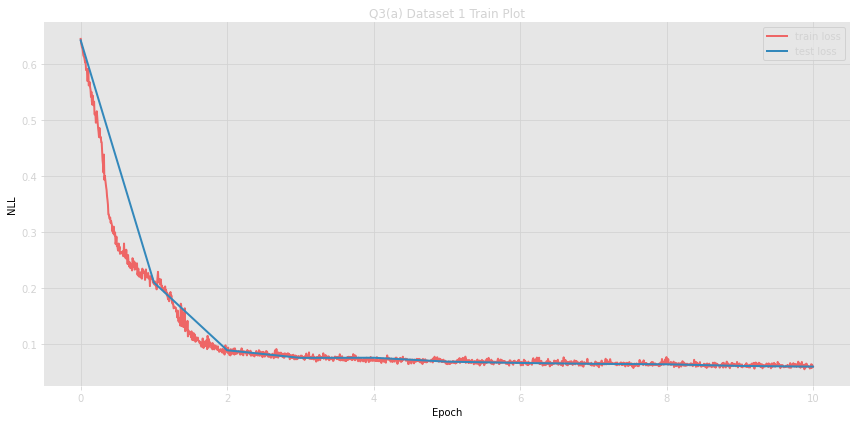

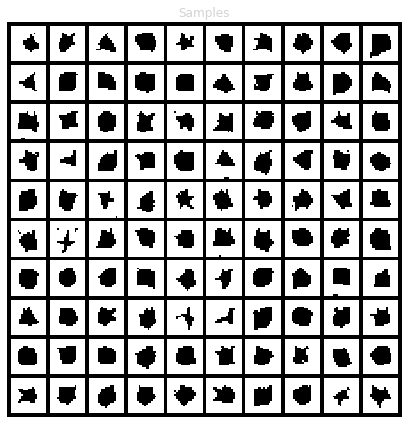

In [ ]:
q3a_save_results(1, q3_a)


Final Test Loss: 0.0860


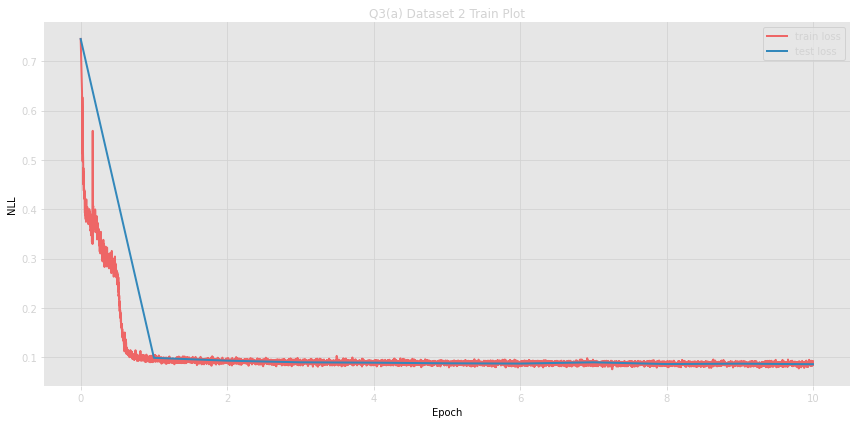

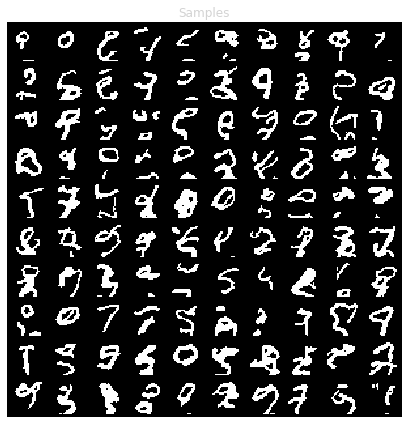

In [ ]:
q3a_save_results(2, q3_a)

## Part (b) PixelCNN on Colored Shapes and MNIST: Independent Color Channels

For the next two parts, we'll work with color images (shapes and MNIST). Run the cell below to visualize the dataset.

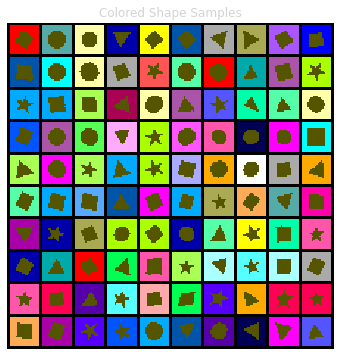

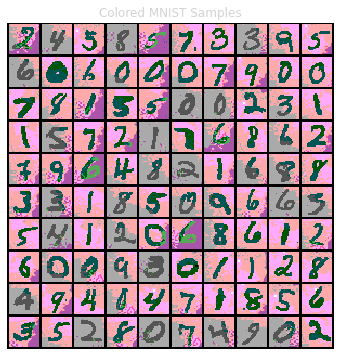

In [ ]:
visualize_q3b_data(1)
visualize_q3b_data(2)

Now, implement a PixelCNN to support RGB color channels (or augment your existing implementation). **First, implement a PixelCNN that assumes color channels as independent.** More formally, we model the following parameterized distribution:

$$p_\theta(x) = \prod_{i=1}^{HW}\prod_{c=1}^C p_\theta(x_i^c | x_{<i})$$

Here are some tips that you may find useful for designing and training these models:
* You will need a 4-way softmax for every prediction, as opposed to a 256-way softmax in the PixelCNN paper, since the dataset is quantized to two bits per color channel
* You can set number of filters for each convolutions to 120. You can use the ReLU nonlinearity throughout.
* Use a stack of 8 residual block architecture from [Figure 5](https://arxiv.org/abs/1601.06759) but with 7 x 7 masked convolutions in the middle instead of 3 x 3 masked convolutions
* Consider using [layer normalization](https://arxiv.org/abs/1607.06450) to improve performance. However, be careful to maintain the autoregressive property.
* With a learning rate of $10^{-3}$ and a batch size of 128, it should take a few minutes to run on the shapes dataset, and about 50-60 minutes on MNIST.

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model



### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
z = torch.zeros(5, 5)

In [ ]:
z[:5//2, :] = 1
z[:5//2, :5//2] = 2
z

tensor([[2., 2., 1., 1., 1.],
        [2., 2., 1., 1., 1.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

In [ ]:
z[:5//2, :] = 2
z

tensor([[2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 2.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

In [ ]:
class PixelConv2d_RGB(nn.Conv2d):
  """
  PixelConv2d for greyscale
  """
  def __init__(self, in_channels, out_channels, kernel_size, mask_type, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros'):
    super().__init__(in_channels, out_channels, kernel_size, 
                     stride=stride, padding=padding, dilation=dilation,
                     groups=groups, bias=bias, padding_mode=padding_mode)

    N, C, K, K = self.weight.shape
    self.mask_type = mask_type
    self.register_buffer('mask', torch.zeros_like(self.weight))

    half = int(K * K / 2)
    threshold = half if self.mask_type == 'a' else half + 1
    idx = 0
    self.mask[:, :, K // 2, ]

    while idx < threshold:
      i, j = divmod(idx, K)
      self.mask[:, :, i, j] = 1
      idx += 1

  def forward(self, input):
    return F.conv2d(input, self.weight * self.mask, self.bias, self.stride, 
                    self.padding, self.dilation, self.groups)

In [ ]:
class LayerNorm(nn.LayerNorm):
  def __init__(self, *args, **kwargs):
    super().__init__(*args, **kwargs)

  def forward(self, x):
    x = x.permute(0, 2, 3, 1)
    x = super().forward(x)
    return x.permute(0, 3, 1, 2)

In [ ]:
class ResidualBlock(nn.Module):
  def __init__(self, num_channels):
    super().__init__()
    residual_size = num_channels // 2
    self.block = nn.ModuleList([nn.ReLU(),
                                PixelConv2d_RGB(num_channels, residual_size, 1, 'b'),
                                nn.ReLU(),
                                PixelConv2d_RGB(residual_size, residual_size, 7, 'b', padding=3),
                                nn.ReLU(),
                                PixelConv2d_RGB(residual_size, num_channels, 1, 'b')])

  def forward(self, x):
    y = x
    for layer in self.block:
      y = layer(y)
    return x + y

In [ ]:
class PixelCNN_RGB(nn.Module):
  def __init__(self, num_hidden_layers=3, num_residual_blocks=8, num_fc_layers=1, num_filters=64):    
    """
    A  7×7  masked type A convolution
    5   7×7  masked type B convolutions
    2   1×1  masked type B convolutions
    """
    super().__init__()

    C = 3
    # input_channels corresponds to the 3 RGB colors
    layers = [PixelConv2d_RGB(C, num_filters, 7,'a', padding=3)] + \
             [LayerNorm(num_filters), nn.ReLU(), PixelConv2d_RGB(num_filters, num_filters, 3, 'b', padding=1)] * num_hidden_layers + \
             [LayerNorm(num_filters), nn.ReLU(), ResidualBlock(num_filters)] * num_residual_blocks + \
             [LayerNorm(num_filters), nn.ReLU(), PixelConv2d_RGB(num_filters, num_filters, 1, 'b')] * num_fc_layers + \
             [LayerNorm(num_filters), nn.ReLU(), PixelConv2d_RGB(num_filters, 4 * C, 1, 'b')] 
             # there are 4 output logits per channel so we can make a 4-way softmax for each

    self.layers = nn.Sequential(*layers)

  def sample(self, image_shape, num_samples):
    H, W, C = image_shape
    samples = torch.zeros(num_samples, C, H, W, device=ptu.device) 

    with torch.no_grad():
      for i in range(H):
        for j in range(W):
          for c in range(C):
            start = c*4
            logits = self(samples)
            probs = F.softmax(logits[:, start:start + 4, i, j], dim=1)
            samples[:, c, i, j] = torch.multinomial(probs, 1).squeeze(1)    

    samples = samples.permute(0, 2, 3, 1)
    return samples.detach().cpu().numpy()

  def forward(self, x):
    return self.layers(x)

  def loss(self, x):
    C = x.shape[1]
    x = x.float()
    logits = self(x) 

    loss = 0.
    for c in range(C):
      start = c*4
      probs = F.softmax(logits[:, start:start+4, :, :], dim=1)
      loss += F.cross_entropy(probs, x[:, c, :, :].long())
    return loss

In [ ]:
def q3_b(train_data, test_data, image_shape, dset_id):
  """
  train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  image_shape: (H, W, C), height, width, and # of channels of the image
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, W, C) of samples with values in {0, 1, 2, 3}
  """
  
  train_data = np.transpose(train_data, (0, 3, 1, 2))
  test_data = np.transpose(test_data, (0, 3, 1, 2))

  train_loader = data.DataLoader(train_data, batch_size=128, shuffle=True)
  test_loader = data.DataLoader(test_data, batch_size=128)

  model = PixelCNN_RGB(num_residual_blocks=8, num_fc_layers=0, num_hidden_layers=0, num_filters=120).to(ptu.device)
  optimizer = optim.Adam(model.parameters(), lr=2e-4, betas=(0.5, 0.999))

  train_losses, test_losses = train_epochs(model, train_loader, test_loader, epochs=10, lr=2e-4)

  return train_losses, test_losses, model.sample(image_shape, 100)

### Results

Once you've implemented `q3_b`, execute the cells below to visualize and save your results




Final Test Loss: 2.3638


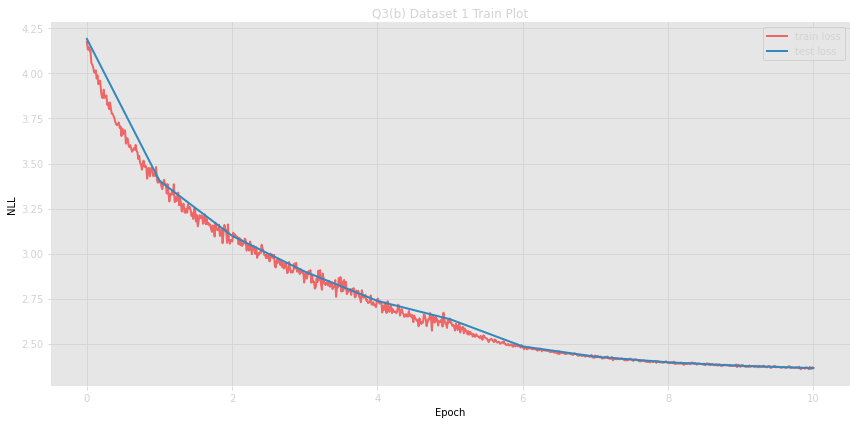

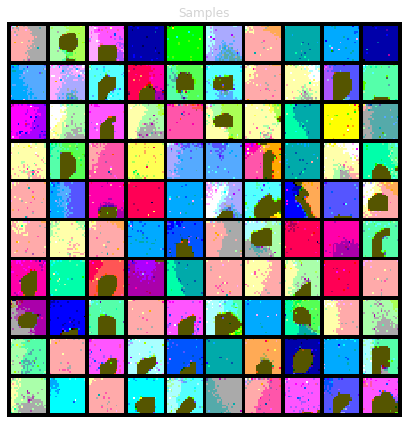

In [ ]:
q3bc_save_results(1, 'b', q3_b)


Final Test Loss: 2.4341


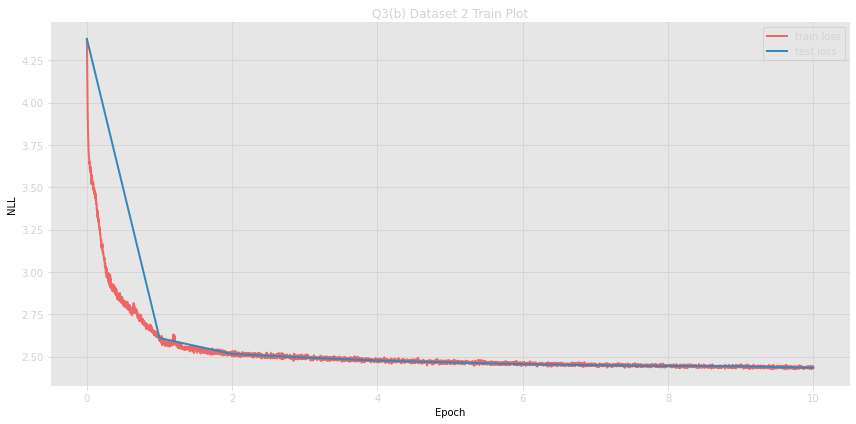

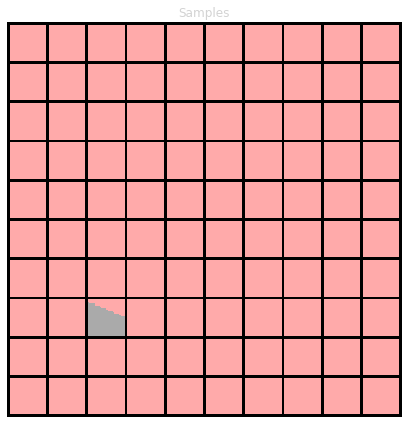

In [ ]:
q3bc_save_results(2, 'b', q3_b)

## Part (c) PixelCNN on Colored Shapes and MNIST: Autoregressive Color Channels

Now, implement a PixelCNN that models **dependent** color channels. Formally, we model the parameterized distribution

$$p_\theta(x) = \prod_{i=1}^{HW}\prod_{c=1}^C p_\theta(x_i^c | x_i^{<c}, x_{<i})$$

To do so, change your masking scheme for the center pixel. Split the filters into 3 groups, only allowing each group to see the groups before (or including the current group, for type B masks) to maintain the autoregressive property.

Training times and hyperparameter settings should be the same as part (b).

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model



### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
def q3_c(train_data, test_data, image_shape, dset_id):
  """
  train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  image_shape: (H, W, C), height, width, and # of channels of the image
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, W, C) of samples with values in {0, 1, 2, 3}
  """
  
  """ YOUR CODE HERE """

### Results

Once you've implemented `q3_c`, execute the cells below to visualize and save your results



Final Test Loss: 0.0236


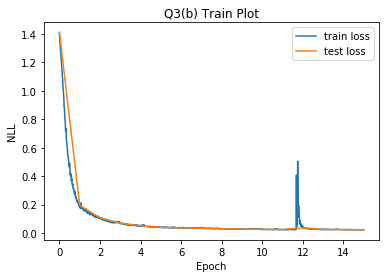

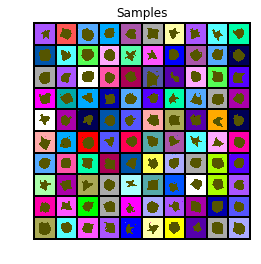

In [ ]:
q3bc_save_results(1, 'c', q3_c)

In [ ]:
q3bc_save_results(2, 'c', q3_c)

## Part (d) Conditional PixelCNNs

In this part, implement and train a **class-conditional** PixelCNN on binary MNIST. Condition on a class label by adding a conditional bias in each convolutional layer. More precisely, in the $\ell$th convolutional layer, compute: 
$$W_\ell * x + b_\ell + V_\ell y$$
where $W_\ell * x + b_\ell$ is a masked convolution (as in previous parts), $V$ is a 2D weight matrix, and $y$ is a one-hot encoding of the class label (where the conditional bias is broadcasted spacially and added channel-wise).

You can use a PixelCNN architecture similar to part (a). Training on the shapes dataset should be quick, and MNIST should take around 10-15 minutes


**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model

### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
def q3_d(train_data, train_labels, test_data, test_labels, image_shape, n_classes, dset_id):
  """
  train_data: A (n_train, H, W, 1) numpy array of binary images with values in {0, 1}
  train_labels: A (n_train,) numpy array of class labels
  test_data: A (n_test, H, W, 1) numpy array of binary images with values in {0, 1}
  test_labels: A (n_test,) numpy array of class labels
  image_shape: (H, W), height and width
  n_classes: number of classes (4 or 10)
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, C, 1) of samples with values in {0, 1}
    where an even number of images of each class are sampled with 100 total
  """
  
  """ YOUR CODE HERE """

### Results

Once you've implemented `q3_d`, execute the cells below to visualize and save your results



Final Test Loss: 0.0368


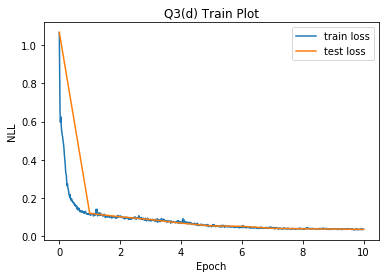

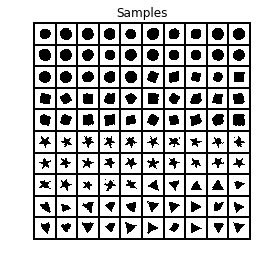

In [ ]:
q3d_save_results(1, q3_d)

In [ ]:
q3d_save_results(2, q3_d)

# Question 4: Bonus Questions (Optional)

## Part (a) Gated PixelCNN
Implement a [Gated PixelCNN](https://arxiv.org/abs/1606.05328) to fix the blind-spot issue, and report training curves, final test loss, and samples.

### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
def q4_a(train_data, test_data, image_shape):
  """
  train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  image_shape: (H, W, C), height, width, and # of channels of the image

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, W, C) of generated samples with values in {0, 1, 2, 3}
  """
  """ YOUR CODE HERE """

### Results

Once you've implemented `q4_a`, execute the cells below to visualize and save your results



In [ ]:
q4a_save_results(q4_a)

## Part (b) Grayscale PixelcNN
Train a [Grayscale PixelCNN](https://arxiv.org/abs/1612.08185) on Colored MNIST. You do not need to use their architecture - stacking standard masked convolutions or residual blocks is fine. First, generate a binary image, and then the 2-bit color image.

### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
def q4_b(train_data, test_data, image_shape):
  """
  train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  image_shape: (H, W, C), height, width, and # of channels of the image

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (50, H, W, 1) of generated binary images in {0, 1}
  - a numpy array of size (50, H, W, C) of conditonally generated color images in {0, 1, 2, 3}
  """
  # You will need to generate the binary image dataset from train_data and test_data
  
  """ YOUR CODE HERE """

### Results

Once you've implemented `q4_b`, execute the cells below to visualize and save your results



In [ ]:
q4b_save_results(q4_b)

## Part (c) Parallel Multiscale PixelCNN
One large disadvantage of autoregressive models is their slow sampling speed, since they require one network evaluation per feature. However, there are existing methods which introduce different independence assumptions to allow for parallelism when sampling. Implement a [Parallel PixelCNN](https://arxiv.org/abs/1703.03664) on 56 x 56 MNIST images, with a base size of 7 x 7 and upscaling by a factor of 2. Sampling should be very quick (< 1s). Architectures may vary, but using small PixelCNN implementation similar to previous parts and small ResNets should suffice

### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
def q4_c(train_data, test_data):
  """
  train_data: A (60000, 56, 56, 1) numpy array of grayscale images with values in {0, 1}
  test_data: A (10000, 56, 56, 1) numpy array of grayscale images with values in {0, 1}
  image_shape: (H, W), height and width

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, 56, 56, 1) of generated samples with values in {0, 1}
  """
 
  """ YOUR CODE HERE """

### Results

Once you've implemented `q4_c`, execute the cells below to visualize and save your results



In [ ]:
q4c_save_results(q4_c)